# Data Analytics Project - Models

# Pair 4 - ASHOKLEY LSTM

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


---

# 2. Get Pair 4 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair4/Pair4_orders.csv')
orders_df.head()

,Date,ASHOKLEY_Close,TATAMTRDVR_Close,Spread,zscore,Orders
0,2019-05-17,84.500000,83.199997,1.300003,-1.764996,LONG
1,2019-05-20,87.550003,88.849998,-1.299995,-2.747445,LONG
2,2019-05-21,88.250000,83.150002,5.099998,-0.329109,FLAT
3,2019-05-22,87.849998,85.400002,2.449997,-1.330453,FLAT
4,2019-05-23,88.849998,84.849998,4.000000,-0.744760,FLAT


In [3]:
orders_df.tail()

,Date,ASHOKLEY_Close,TATAMTRDVR_Close,Spread,zscore,Orders
57,2019-08-07,61.150002,55.650002,5.500000,-0.177963,FLAT
58,2019-08-08,63.549999,58.750000,4.799999,-0.442469,FLAT
59,2019-08-09,64.300003,58.200001,6.100002,0.048757,FLAT
60,2019-08-13,61.549999,57.700001,3.849998,-0.801441,FLAT
61,2019-08-14,62.549999,57.349998,5.200001,-0.291322,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

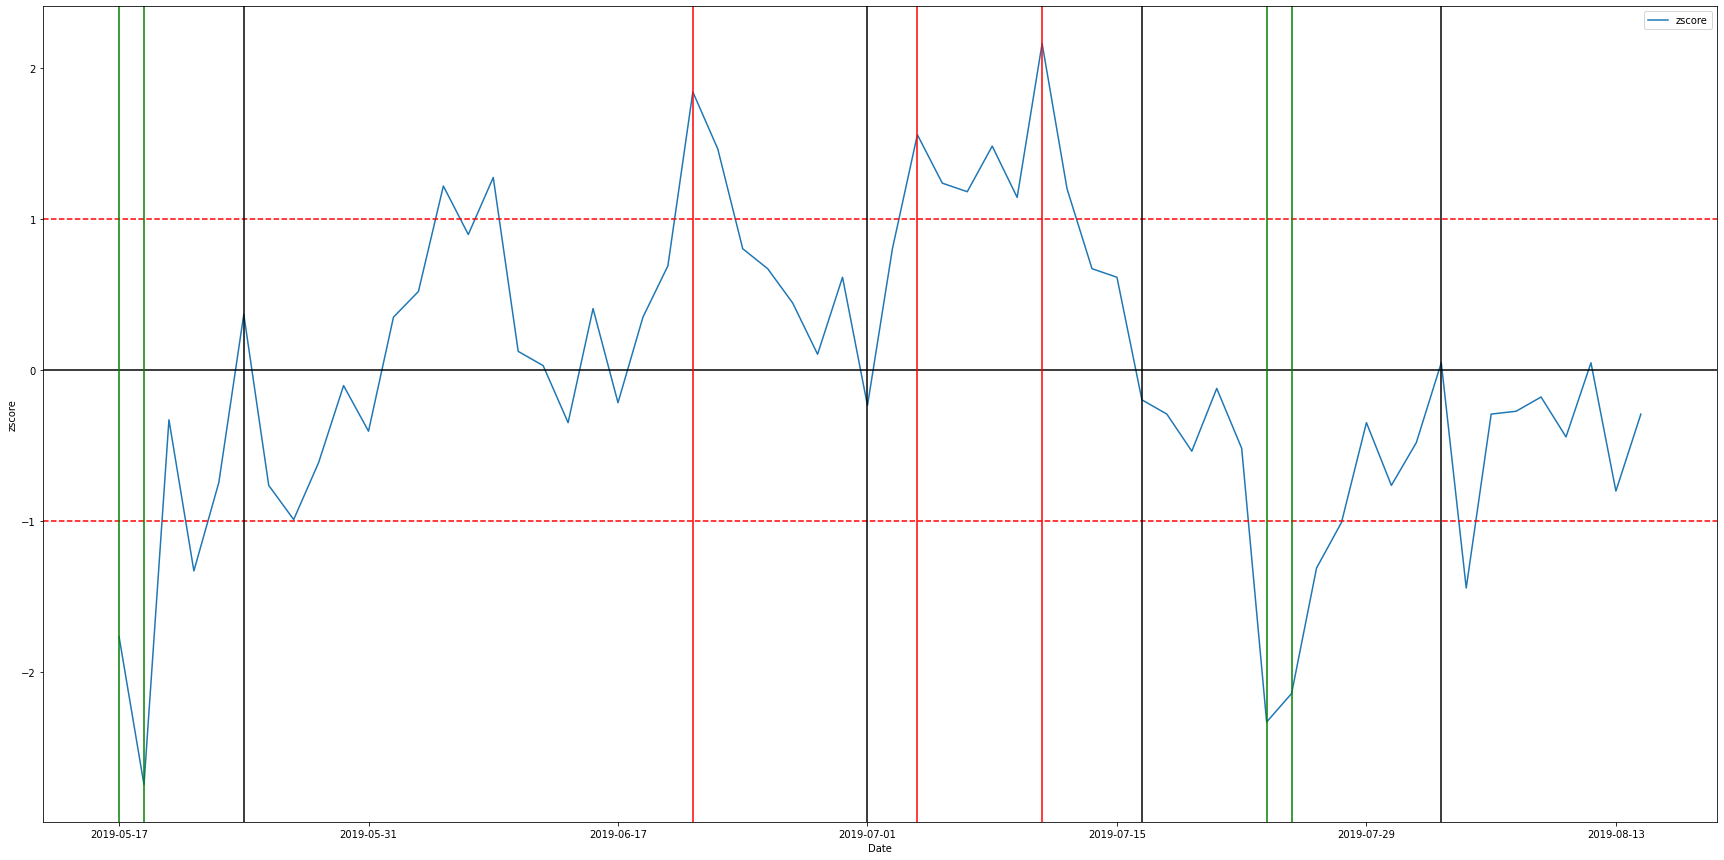

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

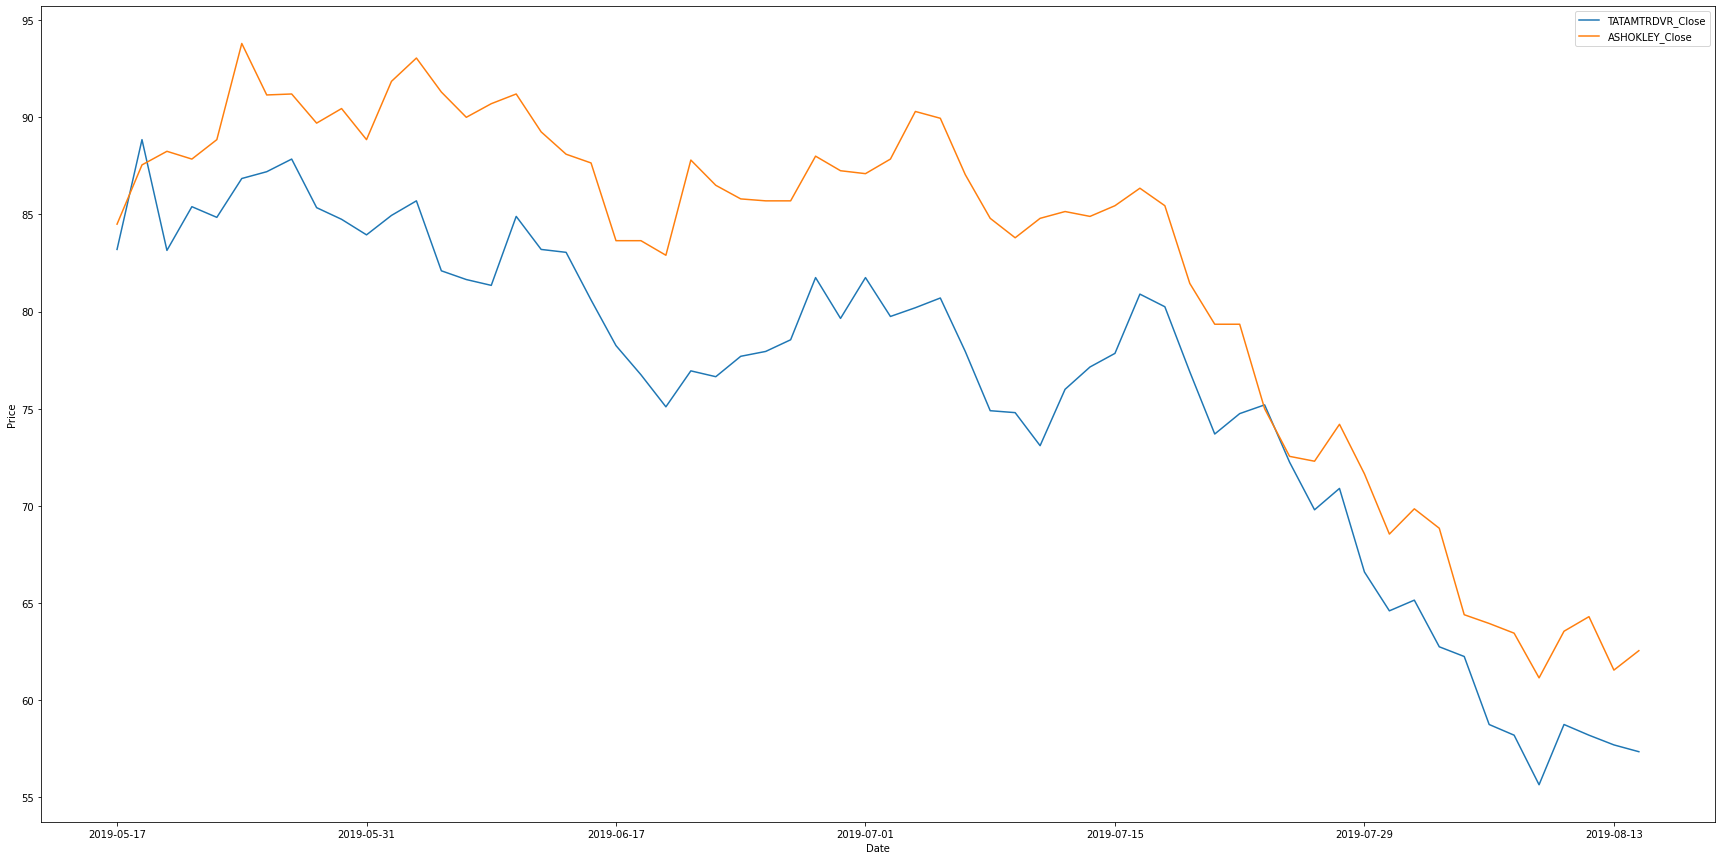

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['TATAMTRDVR_Close', 'ASHOKLEY_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. ASHOKLEY Linear Regression Model

## 3.1. Get the Complete ASHOKLEY dataset

In [6]:
ashokley_df = pd.read_csv("../../Storage/Companies_with_names_exchange/ASHOKLEYNSE.csv")
ashokley_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,81.500000,79.150002,80.500000,81.000000,12823600.0,81.000000,ASHOKLEY,NSE
1,2017-01-03,81.550003,80.449997,81.400002,81.050003,7610206.0,81.050003,ASHOKLEY,NSE
2,2017-01-04,84.550003,81.250000,81.500000,83.849998,14148219.0,83.849998,ASHOKLEY,NSE
3,2017-01-05,84.949997,82.800003,84.650002,83.949997,10474833.0,83.949997,ASHOKLEY,NSE
4,2017-01-06,85.699997,83.150002,84.199997,85.300003,10508449.0,85.300003,ASHOKLEY,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get ASHOKLEY training data

### 3.2.1 Get complete ashokley dataset

In [7]:
ashokley_df = ashokley_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
ashokley_df.head()

,Date,Close
0,2017-01-02,81.000000
1,2017-01-03,81.050003
2,2017-01-04,83.849998
3,2017-01-05,83.949997
4,2017-01-06,85.300003


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
ashokley_df_train = ashokley_df[ashokley_df['Date'] >= '2017-09-03']
ashokley_df_train.head()

,Date,Close
166,2017-09-04,113.349998
167,2017-09-05,113.000000
168,2017-09-06,112.150002
169,2017-09-07,111.900002
170,2017-09-08,115.150002


In [9]:
ashokley_df_train = ashokley_df_train[ashokley_df_train['Date'] <= '2018-09-04']
ashokley_df_train.tail()

,Date,Close
412,2018-08-29,131.899994
413,2018-08-30,130.850006
414,2018-08-31,129.050003
415,2018-09-03,133.449997
416,2018-09-04,127.849998


### 3.2.3 Get the training data

In [10]:
ashokley_train = ashokley_df_train.copy()

In [11]:
ashokley_train = ashokley_train.reset_index(drop=True)
ashokley_train = ashokley_train.copy()
ashokley_train.head()

,Date,Close
0,2017-09-04,113.349998
1,2017-09-05,113.000000
2,2017-09-06,112.150002
3,2017-09-07,111.900002
4,2017-09-08,115.150002


In [12]:
ashokley_train_plot_copy = ashokley_train.copy()
ashokley_train.tail()

,Date,Close
246,2018-08-29,131.899994
247,2018-08-30,130.850006
248,2018-08-31,129.050003
249,2018-09-03,133.449997
250,2018-09-04,127.849998


In [13]:
ashokley_train = ashokley_train.drop(columns=['Date'])
ashokley_train = ashokley_train.values
ashokley_train

array([[113.34999847],
       [113.        ],
       [112.15000153],
       [111.90000153],
       [115.15000153],
       [116.19999695],
       [118.30000305],
       [117.69999695],
       [117.05000305],
       [116.80000305],
       [118.55000305],
       [118.15000153],
       [119.34999847],
       [117.30000305],
       [114.30000305],
       [113.        ],
       [113.5       ],
       [112.19999695],
       [116.75      ],
       [123.09999847],
       [122.44999695],
       [122.5       ],
       [122.5       ],
       [124.84999847],
       [123.80000305],
       [126.44999695],
       [124.55000305],
       [125.34999847],
       [125.34999847],
       [127.44999695],
       [128.44999695],
       [130.6000061 ],
       [129.1499939 ],
       [128.19999695],
       [128.6000061 ],
       [128.5       ],
       [131.1499939 ],
       [127.80000305],
       [128.69999695],
       [131.19999695],
       [126.44999695],
       [124.59999847],
       [123.65000153],
       [125

In [14]:
len(ashokley_train)

251

## 3.3. Get ASHOKLEY Test Data

In [15]:
ashokley_test = ashokley_df[(ashokley_df['Date'] >= '2018-09-04') & (ashokley_df['Date'] <= '2018-12-03')].copy()
ashokley_test.head()

,Date,Close
416,2018-09-04,127.849998
417,2018-09-05,127.449997
418,2018-09-06,129.699997
419,2018-09-07,132.000000
420,2018-09-10,129.649994


In [16]:
ashokley_test.tail()

,Date,Close
470,2018-11-27,110.300003
471,2018-11-28,108.349998
472,2018-11-29,110.150002
473,2018-11-30,112.349998
474,2018-12-03,107.150002


In [17]:
ashokley_test.reset_index(drop=True, inplace=True)
ashokley_test.index += 251
ashokley_test.head()

,Date,Close
251,2018-09-04,127.849998
252,2018-09-05,127.449997
253,2018-09-06,129.699997
254,2018-09-07,132.000000
255,2018-09-10,129.649994


In [18]:
ashokley_test_plot_copy = ashokley_test.copy()
ashokley_test = ashokley_test.drop(columns=['Date'])
ashokley_test = ashokley_test.values
ashokley_test

array([[127.84999847],
       [127.44999695],
       [129.69999695],
       [132.        ],
       [129.6499939 ],
       [127.75      ],
       [127.84999847],
       [131.25      ],
       [127.44999695],
       [126.40000153],
       [125.80000305],
       [122.30000305],
       [120.34999847],
       [121.90000153],
       [120.65000153],
       [120.40000153],
       [119.09999847],
       [120.15000153],
       [119.15000153],
       [118.05000305],
       [107.75      ],
       [109.15000153],
       [110.84999847],
       [114.55000305],
       [111.80000305],
       [115.80000305],
       [117.05000305],
       [120.55000305],
       [114.30000305],
       [112.5       ],
       [112.80000305],
       [111.44999695],
       [116.80000305],
       [112.84999847],
       [113.15000153],
       [115.25      ],
       [115.        ],
       [114.69999695],
       [113.34999847],
       [117.69999695],
       [120.69999695],
       [120.90000153],
       [121.84999847],
       [118

In [19]:
len(ashokley_test)

59

## 3.4 Create and Train ASHOKLEY Model

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(ashokley_train)
scaled_train_data

array([[0.12781956],
       [0.12197163],
       [0.10776949],
       [0.10359238],
       [0.1578948 ],
       [0.17543858],
       [0.2105264 ],
       [0.20050123],
       [0.18964085],
       [0.18546374],
       [0.21470351],
       [0.20802011],
       [0.22807018],
       [0.19381796],
       [0.14369265],
       [0.12197163],
       [0.13032585],
       [0.10860483],
       [0.18462827],
       [0.29072681],
       [0.2798663 ],
       [0.28070178],
       [0.28070178],
       [0.31996658],
       [0.30242279],
       [0.34670005],
       [0.31495412],
       [0.32832079],
       [0.32832079],
       [0.36340848],
       [0.38011692],
       [0.41604021],
       [0.39181277],
       [0.37593981],
       [0.38262334],
       [0.38095239],
       [0.42522965],
       [0.36925654],
       [0.38429403],
       [0.42606512],
       [0.34670005],
       [0.31578947],
       [0.2999165 ],
       [0.33416872],
       [0.27318303],
       [0.22472854],
       [0.16123643],
       [0.104

In [21]:
X_train, y_train = [], []
for i in range(10,len(ashokley_train)):
    X_train.append(scaled_train_data[i-10:i,0])
    y_train.append(scaled_train_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 2s - loss: 0.0174


## 3.5. Get predictions

In [24]:
scaled_test_data = ashokley_test.reshape(-1,1)
scaled_test_data = scaler.transform(scaled_test_data)
scaled_test_data.shape

(59, 1)

In [25]:
X_test = []
for i in range(10, scaled_test_data.shape[0]):
    X_test.append(scaled_test_data[i-10:i,0])
X_test = np.array(X_test)
X_test

array([[ 0.37009188,  0.36340848,  0.40100247,  0.43943192,  0.40016699,
         0.36842107,  0.37009188,  0.42690059,  0.36340848,  0.3458647 ],
       [ 0.36340848,  0.40100247,  0.43943192,  0.40016699,  0.36842107,
         0.37009188,  0.42690059,  0.36340848,  0.3458647 ,  0.33583967],
       [ 0.40100247,  0.43943192,  0.40016699,  0.36842107,  0.37009188,
         0.42690059,  0.36340848,  0.3458647 ,  0.33583967,  0.27736014],
       [ 0.43943192,  0.40016699,  0.36842107,  0.37009188,  0.42690059,
         0.36340848,  0.3458647 ,  0.33583967,  0.27736014,  0.24477861],
       [ 0.40016699,  0.36842107,  0.37009188,  0.42690059,  0.36340848,
         0.3458647 ,  0.33583967,  0.27736014,  0.24477861,  0.27067674],
       [ 0.36842107,  0.37009188,  0.42690059,  0.36340848,  0.3458647 ,
         0.33583967,  0.27736014,  0.24477861,  0.27067674,  0.2497912 ],
       [ 0.37009188,  0.42690059,  0.36340848,  0.3458647 ,  0.33583967,
         0.27736014,  0.24477861,  0.27067674

In [26]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
len(closing_price)

49

In [27]:
print('Mean Absolute Error:', metrics.mean_absolute_error(ashokley_test[10:], closing_price))
print('Mean Squared Error:', metrics.mean_squared_error(ashokley_test[10:], closing_price))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ashokley_test[10:], closing_price)))

Mean Absolute Error: 5.77219001614318
Mean Squared Error: 48.11690256164927
Root Mean Squared Error: 6.936634815358905


## 3.6. Visualize the predicitons vs test data

In [28]:
closing_price_df = pd.DataFrame(closing_price, columns=['price'])
closing_price_df.index += 260
closing_price = closing_price_df['price']
closing_price

260    130.586639
261    130.345734
262    129.851456
263    128.990646
264    128.002686
265    127.106865
266    126.308578
267    125.469696
268    124.557014
269    123.889282
270    123.265297
271    122.125290
272    120.929260
273    119.807472
274    118.853638
275    118.029266
276    117.517822
277    117.355148
278    117.526802
279    117.657845
280    117.669823
281    118.029404
282    118.093369
283    118.220909
284    118.069458
285    118.017906
286    117.869568
287    117.740929
288    117.506538
289    117.545204
290    117.848541
291    118.394150
292    119.156708
293    119.788300
294    120.473969
295    121.003914
296    121.354256
297    120.969757
298    120.112724
299    119.009293
300    117.736320
301    116.387543
302    115.305656
303    114.372765
304    113.759773
305    113.331192
306    112.916473
307    113.187088
308    113.588898
Name: price, dtype: float32

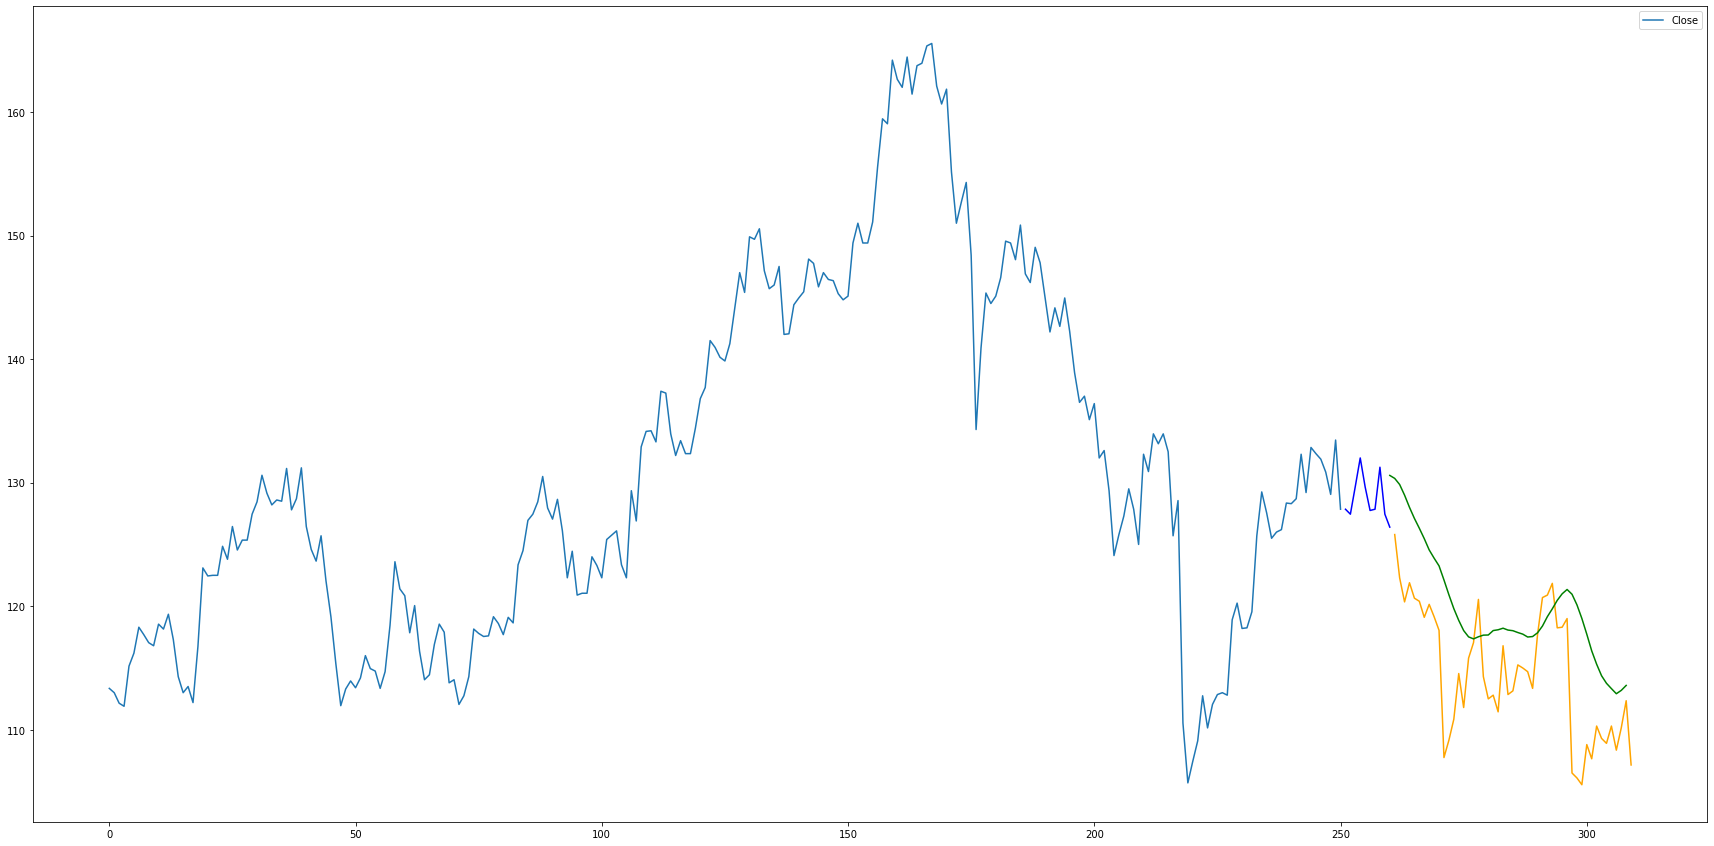

In [29]:
ashokley_model_plt = ashokley_train_plot_copy.plot(y=['Close'], figsize=(30,15))
ashokley_model_plt.plot(ashokley_test_plot_copy["Close"][:10], c='blue')
ashokley_model_plt.plot(ashokley_test_plot_copy["Close"][10:], c='orange')
ashokley_model_plt.plot(closing_price, c='green')

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results in a file

In [30]:
ashokley_predictions_df = pd.read_csv('Ashokley_predicitions.csv')
ashokley_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
0,2019-05-17,84.500000,120.973240,128.025796
1,2019-05-20,87.550003,120.949883,127.611621
2,2019-05-21,88.250000,120.926525,129.149894
3,2019-05-22,87.849998,120.903168,123.576205
4,2019-05-23,88.849998,120.150063,120.873591


In [31]:
ashokley_predictions_df.tail()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
57,2019-08-07,61.150002,116.097397,134.127795
58,2019-08-08,63.549999,116.523128,136.600763
59,2019-08-09,64.300003,NaN,NaN
60,2019-08-13,61.549999,NaN,NaN
61,2019-08-14,62.549999,NaN,NaN


In [32]:
closing_price_df.index -= 250
closing_price_df

,price
10,130.586639
11,130.345734
12,129.851456
13,128.990646
14,128.002686
15,127.106865
16,126.308578
17,125.469696
18,124.557014
19,123.889282


In [33]:
ashokley_predictions_df['LSTM_Close'] = closing_price_df['price']
ashokley_predictions_df

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close,LSTM_Close
0,2019-05-17,84.500000,120.973240,128.025796,NaN
1,2019-05-20,87.550003,120.949883,127.611621,NaN
2,2019-05-21,88.250000,120.926525,129.149894,NaN
3,2019-05-22,87.849998,120.903168,123.576205,NaN
4,2019-05-23,88.849998,120.150063,120.873591,NaN
...,...,...,...,...,...
57,2019-08-07,61.150002,116.097397,134.127795,113.187088
58,2019-08-08,63.549999,116.523128,136.600763,113.588898
59,2019-08-09,64.300003,NaN,NaN,NaN
60,2019-08-13,61.549999,NaN,NaN,NaN


In [34]:
ashokley_predictions_df.to_csv('Ashokley_predicitions.csv', index=False)